In [1]:
import numpy as np

In [2]:
# ロードしたデータを訓練データ用のStringと正解ラベルに分ける
def split_vector(data):
    y = np.zeros(len(data) - 1)
    x = []
    for i, d in enumerate(data):
        if i == len(data) - 1:
            break
        c = 3
        if (d[0] == 'b') : c = 0
        if (d[0] == 't') : c = 1
        if (d[0] == 'e') : c = 2
        y[i] = c
        x.append(d[1])
    
    return (x, y.astype(np.uint8))

In [3]:
# 70
file_path = '../data/NewsAggregatorDataset/'

with open(file_path + 'train.txt') as f:
    train_data = f.read().split('\n')
x_train, y_train = split_vector([d.split('\t') for d in train_data])
print(len(x_train), y_train.shape)

with open(file_path + 'test.txt') as f:
    test_data = f.read().split('\n')
x_test, y_test = split_vector([d.split('\t') for d in test_data])
print(len(x_test), y_test.shape)

with open(file_path + 'valid.txt') as f:
    valid_data = f.read().split('\n')
x_valid, y_valid = split_vector([d.split('\t') for d in valid_data])
print(len(x_valid), y_valid.shape)

8708 (8708,)
1099 (1099,)
1088 (1088,)


In [4]:
import MeCab
from gensim.models import KeyedVectors
news_path = '../data/GoogleNews-vectors-negative300.bin'
words = KeyedVectors.load_word2vec_format(news_path, binary = True)

In [5]:
def vec2sum(vector_data, dim):
    mecab = MeCab.Tagger()
    vector_sum = np.zeros((len(vector_data), dim))
    for i, v in enumerate(vector_data):
        morph = mecab.parse(v)
        words_ = morph.split('\n')
        vector = np.zeros(dim)
        cnt = 0
        for word in words_:
            noun = word.split('\t')[0]
            if noun == 'EOS':
                if cnt == 0:
                    break
                vector_sum[i] = (vector / cnt)
                break
            
            try :
                cnt += 1
                vector += words[noun]
            except KeyError as error:
                continue
    return vector_sum

In [6]:
x_feature = vec2sum(x_train, 300)
print(len(x_train))
print(x_feature.shape)

8708
(8708, 300)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.autograd import Variable
dim = words['US'].shape[0] # 単語ベクトルの次元

In [8]:
# 71
w = np.random.rand(dim, 4)
w = torch.randn(dim, 4, requires_grad = True)
print(w.shape)

# 1次元=>2次元
x_f = np.array([x_feature[0]]) 
x_f = torch.tensor(x_f, requires_grad = True)
print(x_f.shape)

x_f_w = func.softmax(torch.mm(x_f.float(), w.float()))
print(x_f_w)

torch.Size([300, 4])
torch.Size([1, 300])
tensor([[0.0803, 0.3842, 0.3113, 0.2243]], grad_fn=<SoftmaxBackward>)


/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [9]:
# 複数事例
x_f_Y = torch.tensor(x_feature[0:4], requires_grad = True)
Y_ = func.softmax(torch.mm(x_f_Y.float(), w.float()).float(), dim = 1)
print(Y_)

tensor([[0.0803, 0.3842, 0.3113, 0.2243],
        [0.2538, 0.4910, 0.0384, 0.2169],
        [0.3479, 0.3272, 0.2324, 0.0925],
        [0.1113, 0.3930, 0.2663, 0.2294]], grad_fn=<SoftmaxBackward>)


In [10]:
from math import exp, log

criterion = nn.CrossEntropyLoss()
print(y_train[0])
y = criterion(x_f_w, torch.tensor(np.array([y_train[0]])).long())
print(x_f_w)
y.backward()
print(y)
print(w.grad)

# 検算
x_sum = 0
for i in x_f_w[0]:
    x_sum += exp(i)
x_ = x_f_w[0][y_train[0]]
ans = -x_ + log(x_sum)
print(ans)

2
tensor([[0.0803, 0.3842, 0.3113, 0.2243]], grad_fn=<SoftmaxBackward>)
tensor(1.3313, grad_fn=<NllLossBackward>)
tensor([[-0.0003, -0.0020,  0.0034, -0.0010],
        [ 0.0022,  0.0133, -0.0222,  0.0068],
        [-0.0002, -0.0015,  0.0026, -0.0008],
        ...,
        [-0.0017, -0.0103,  0.0172, -0.0052],
        [-0.0006, -0.0038,  0.0064, -0.0020],
        [-0.0003, -0.0018,  0.0029, -0.0009]])
tensor(1.3313, grad_fn=<AddBackward0>)


In [11]:
# 複数事例
Y = criterion(Y_, torch.tensor(y_train[0:4]).long())
print(Y)
Y.backward()
print(w.grad)

tensor(1.3869, grad_fn=<NllLossBackward>)
tensor([[-0.0033,  0.0036,  0.0012, -0.0014],
        [-0.0015,  0.0213, -0.0309,  0.0111],
        [ 0.0020, -0.0038,  0.0036, -0.0018],
        ...,
        [-0.0033, -0.0096,  0.0210, -0.0081],
        [-0.0004, -0.0036,  0.0072, -0.0032],
        [ 0.0021, -0.0040,  0.0062, -0.0043]])


In [12]:
import time

In [13]:
class MyNet(nn.Module):
    def __init__(self, input_size):
        super(MyNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 4)
        
    def forward(self, x):
        x = func.softmax(self.fc1(x))
        return x

In [14]:
model = MyNet(dim)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
num_epochs = 100
save_path = '../data/params.tar'

In [15]:
def train(num_epochs, num_batches, x_train, y_train, optimizer, model):
    
    # epoch毎の損失と精度を保持するリスト
    losses = []
    accs = []

    num_data = x_train.shape[0]
    
    for epoch in range(num_epochs):

        # epoch毎の損失と精度
        running_loss = 0.0
        accuracy = 0.0
        
        # 開始時間のメモ
        t = time.time()
        
        # ミニバッチ学習のために訓練データのインデックスをランダムに並べ替える
        index = np.random.permutation(num_data)
        
        for i in range(0, num_data, num_batches):
            # NNへの入力と正解ラベル
            in_, label = torch.tensor(x_train[index[i : i + num_batches if i + num_batches < num_data else num_data]]), \
                         torch.tensor(y_train[index[i : i + num_batches if i + num_batches < num_data else num_data]]).long()
        
            # 最適化関数の初期化
            optimizer.zero_grad()
        
            # 予測とロスの計算
            out_ = model(in_.float())
            loss = criterion(out_, label)
            
            _, idx = torch.max(out_, 1)
            
            # バッチ数のラベルが出てくるので，いくつ正解しているかカウント
            cnt = 0
            for i in range(idx.shape[0]):
                if idx[i] == label[i]:
                    cnt += 1
            accuracy += cnt / idx.shape[0]
        
            # パラメーターの更新
            loss.backward()
            optimizer.step()
            running_loss += loss.data
        
        # 各種データの出力・保存
        num_loop = num_data / num_batches
        print('[ epoch:{0}, time:{3} ]  acc: {1:.4f}  loss:{2:.4f}'.format(epoch + 1, accuracy / num_loop, running_loss / num_loop, time.time() - t))
        accs.append(accuracy / num_loop)
        losses.append(running_loss / num_loop)
        
        # 状況の保存
        torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': running_loss / num_loop,
          }, save_path)
        
    return (model, accs, losses)

In [16]:
def eval(x, y, model):
    total = x.shape[0]
    cnt = 0
    for i in range(x.shape[0]):
        in_, label = torch.from_numpy(np.array([x[i]])), \
                     torch.tensor(np.array([y[i]])).long()
        p = model(in_.float())
        _, index = torch.max(p, 1)
        if index == label:
            cnt += 1
    return (cnt * 100 / total)

In [17]:
model, accs, losses = train(num_epochs, 1, x_feature, y_train, optimizer, model)

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


[ epoch:1, time:2.4124608039855957 ]  acc: 0.8096  loss:0.9744
[ epoch:2, time:2.3835861682891846 ]  acc: 0.8228  loss:0.9322
[ epoch:3, time:2.3446249961853027 ]  acc: 0.8246  loss:0.9265
[ epoch:4, time:2.354555130004883 ]  acc: 0.8259  loss:0.9237
[ epoch:5, time:2.348209857940674 ]  acc: 0.8275  loss:0.9218
[ epoch:6, time:2.3424880504608154 ]  acc: 0.8276  loss:0.9204
[ epoch:7, time:2.334503173828125 ]  acc: 0.8283  loss:0.9193
[ epoch:8, time:2.3277649879455566 ]  acc: 0.8290  loss:0.9184
[ epoch:9, time:2.335322141647339 ]  acc: 0.8289  loss:0.9177
[ epoch:10, time:2.335034132003784 ]  acc: 0.8297  loss:0.9172
[ epoch:11, time:2.4011900424957275 ]  acc: 0.8294  loss:0.9166
[ epoch:12, time:2.375515937805176 ]  acc: 0.8294  loss:0.9162
[ epoch:13, time:2.3343920707702637 ]  acc: 0.8303  loss:0.9157
[ epoch:14, time:2.3292810916900635 ]  acc: 0.8307  loss:0.9153
[ epoch:15, time:2.3154046535491943 ]  acc: 0.8310  loss:0.9150
[ epoch:16, time:2.358058214187622 ]  acc: 0.8308  loss

In [18]:
print(eval(vec2sum(x_test, dim), y_test, model))

93.72156505914468


/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [19]:
print(eval(x_feature, y_train, model))

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


94.00551217271475


In [20]:
print(eval(vec2sum(x_valid, dim), y_valid, model))

92.73897058823529


/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

[]

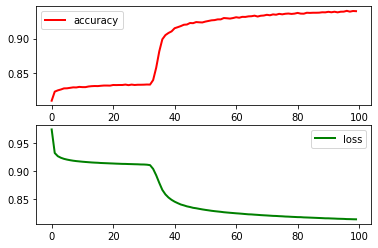

In [22]:
x = np.arange(len(accs))
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(x, accs, color = 'red', linewidth = 2, label = 'accuracy')
ax2 = fig.add_subplot(212)
ax2.plot(x, losses, color = 'green', linewidth = 2, label = 'loss')
ax.legend()
ax2.legend()
plt.plot()

In [23]:
model, accs, losses = train(num_epochs, 2, x_feature, y_train, optimizer, model)

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


[ epoch:1, time:1.2299458980560303 ]  acc: 0.9403  loss:0.8131
[ epoch:2, time:1.2168068885803223 ]  acc: 0.9398  loss:0.8130
[ epoch:3, time:1.2212750911712646 ]  acc: 0.9403  loss:0.8129
[ epoch:4, time:1.2183418273925781 ]  acc: 0.9401  loss:0.8128
[ epoch:5, time:1.2208530902862549 ]  acc: 0.9405  loss:0.8128
[ epoch:6, time:1.2097220420837402 ]  acc: 0.9406  loss:0.8127
[ epoch:7, time:1.2130041122436523 ]  acc: 0.9403  loss:0.8126
[ epoch:8, time:1.2185940742492676 ]  acc: 0.9413  loss:0.8125
[ epoch:9, time:1.2233190536499023 ]  acc: 0.9410  loss:0.8125
[ epoch:10, time:1.2464919090270996 ]  acc: 0.9406  loss:0.8124
[ epoch:11, time:1.2311592102050781 ]  acc: 0.9412  loss:0.8123
[ epoch:12, time:1.2162859439849854 ]  acc: 0.9414  loss:0.8122
[ epoch:13, time:1.230281114578247 ]  acc: 0.9417  loss:0.8121
[ epoch:14, time:1.2297370433807373 ]  acc: 0.9417  loss:0.8120
[ epoch:15, time:1.2217228412628174 ]  acc: 0.9420  loss:0.8120
[ epoch:16, time:1.229909896850586 ]  acc: 0.9412 

In [24]:
model, accs, losses = train(num_epochs, 4, x_feature, y_train, optimizer, model)

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


[ epoch:1, time:0.7223527431488037 ]  acc: 0.9467  loss:0.8070
[ epoch:2, time:0.7348952293395996 ]  acc: 0.9468  loss:0.8070
[ epoch:3, time:0.7094190120697021 ]  acc: 0.9467  loss:0.8070
[ epoch:4, time:0.7223870754241943 ]  acc: 0.9468  loss:0.8069
[ epoch:5, time:0.7000508308410645 ]  acc: 0.9471  loss:0.8069
[ epoch:6, time:0.7212178707122803 ]  acc: 0.9471  loss:0.8069
[ epoch:7, time:0.6981651782989502 ]  acc: 0.9471  loss:0.8069
[ epoch:8, time:0.6987061500549316 ]  acc: 0.9471  loss:0.8068
[ epoch:9, time:0.7117719650268555 ]  acc: 0.9467  loss:0.8068
[ epoch:10, time:0.6960241794586182 ]  acc: 0.9469  loss:0.8068
[ epoch:11, time:0.6966609954833984 ]  acc: 0.9467  loss:0.8068
[ epoch:12, time:0.664086103439331 ]  acc: 0.9472  loss:0.8067
[ epoch:13, time:0.6468842029571533 ]  acc: 0.9468  loss:0.8067
[ epoch:14, time:0.69569993019104 ]  acc: 0.9476  loss:0.8067
[ epoch:15, time:0.6935529708862305 ]  acc: 0.9472  loss:0.8067
[ epoch:16, time:0.6890969276428223 ]  acc: 0.9473  

In [25]:
class MyNet2(nn.Module):
    def __init__(self, input_size, h_size, output_size):
        super(MyNet2, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, h_size)
        self.fc2 = torch.nn.Linear(h_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = func.relu(x)
        x = self.fc2(x)
        x = func.softmax(x)
        
        return x

In [26]:
model = MyNet2(dim, 100, 4)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
num_epochs = 100
save_path = '../data/params.tar'

In [27]:
model, accs2, losses2 = train(num_epochs, 2, x_feature, y_train, optimizer, model)

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


[ epoch:1, time:1.9604780673980713 ]  acc: 0.7980  loss:0.9566
[ epoch:2, time:1.9771151542663574 ]  acc: 0.8275  loss:0.9162
[ epoch:3, time:1.977762222290039 ]  acc: 0.8302  loss:0.9133
[ epoch:4, time:1.9852077960968018 ]  acc: 0.8315  loss:0.9117
[ epoch:5, time:1.9634521007537842 ]  acc: 0.8329  loss:0.9102
[ epoch:6, time:1.950193166732788 ]  acc: 0.8334  loss:0.9081
[ epoch:7, time:1.9881999492645264 ]  acc: 0.8423  loss:0.8988
[ epoch:8, time:1.9931762218475342 ]  acc: 0.8706  loss:0.8739
[ epoch:9, time:1.972059726715088 ]  acc: 0.8817  loss:0.8624
[ epoch:10, time:2.067525863647461 ]  acc: 0.9057  loss:0.8441
[ epoch:11, time:1.9598169326782227 ]  acc: 0.9229  loss:0.8267
[ epoch:12, time:1.9589958190917969 ]  acc: 0.9262  loss:0.8206
[ epoch:13, time:1.940685749053955 ]  acc: 0.9274  loss:0.8177
[ epoch:14, time:1.9604358673095703 ]  acc: 0.9328  loss:0.8139
[ epoch:15, time:1.970794916152954 ]  acc: 0.9356  loss:0.8119
[ epoch:16, time:1.9566781520843506 ]  acc: 0.9370  los

In [28]:
print(eval(vec2sum(x_valid, dim), y_valid, model))

92.37132352941177


/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


[]

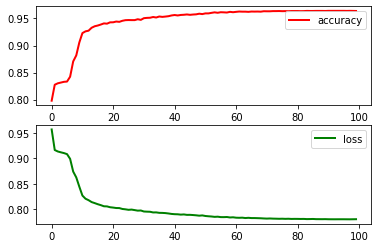

In [29]:
x = np.arange(len(accs2))
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(x, accs2, color = 'red', linewidth = 2, label = 'accuracy')
ax2 = fig.add_subplot(212)
ax2.plot(x, losses2, color = 'green', linewidth = 2, label = 'loss')
ax.legend()
ax2.legend()
plt.plot()